# DATA PREPARATION

In [2]:
import gc
import io
import os
import random
import time
import wandb
from tqdm import tqdm

import matplotlib.pyplot as plt
from PIL import Image
from skimage.metrics import structural_similarity as ssim

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
from torchvision.transforms import Compose
from torchmetrics.functional.image import structural_similarity_index_measure as ssim

In [3]:
class DF2KDataset(Dataset):
    def __init__(self, hr_images_path, random_crop:bool=True, transforms:Compose=None, output_size:tuple=(256, 256), seed:int=1989):
        super(DF2KDataset, self).__init__()
        
        self.hr_images_path = hr_images_path
        
        hr_images_list = os.listdir(hr_images_path)
        
        self.hr_images_list = [hr_images_path + image_name for image_name in hr_images_list]
        
        self.random_crop = random_crop
        self.transforms = transforms
        self.output_size = output_size
        self.seed = seed
    
    def __getitem__(self, idx):
        hr_image_path = self.hr_images_list[idx]
        lr_image_path = hr_image_path.replace('.png', 'x4.png').replace('HR', 'LR_bicubic_X4')
        
        hr_image = Image.open(hr_image_path)
        lr_image = Image.open(lr_image_path)
        
        # -------------------- RANDOM CROP -------------------- #
        if self.random_crop:
            w, h = hr_image.size
            th, tw = self.output_size
            random.seed(self.seed + idx)
            i = random.choice(list(range(0, h-th+1, 4)))
            j = random.choice(list(range(0, w-tw+1, 4)))

            hr_image = transforms.functional.crop(hr_image, i, j, th, tw)
            lr_image = transforms.functional.crop(lr_image, i//4, j//4, th//4, tw//4)
        
        # -------------------- OTHER TRANSFORMATIONS -------------------- #
        if self.transforms:
            torch.manual_seed(seed=self.seed)
            hr_image = self.transforms(hr_image)
            torch.manual_seed(seed=self.seed)
            lr_image = self.transforms(lr_image)
            
        # -------------------- TO TENSOR -------------------- #
        hr_image = transforms.functional.to_tensor(hr_image)
        lr_image = transforms.functional.to_tensor(lr_image)
        
        return hr_image, lr_image
        
    def __len__(self):
        return len(self.hr_images_list)

In [4]:
class DF2KDataLoader(DataLoader):
    def __init__(self, hr_images_path, 
                 random_crop:bool=True, transforms:Compose=None, output_size:tuple=(256, 256), seed:int=1989,
                 batch_size:int=1, shuffle:bool=True, num_crops:int=1):
        """
        - hr_images_path: str
            Path to the high-resolution images
        - random_crop: bool
            Whether to crop the images. Default is True. You might want to crop on the training set, but not on the validation set.
        - transforms: Compose
            A Compose of transformations, applied similarly on both high-res and low-res images.
            >> NOTE: Some transformations might worsen the quality of image, so consider carefully.
        - output_size: tuple
            Size of the random crop applied to an image. Default is 256x256.
            >> NOTE: Only meaningful when `random_crop` is True.
        - seed: int
            A random number, meant to keep all transformations the same for high-res and low-res images
        - num_crops: int
            The number of random crops applied to an image. Size of dataset is multiplied accordingly. Default is 1.
            >> NOTE: Only meaningful when `random_crop` is True.
        """
        if random_crop and num_crops > 1:
            random.seed(1989)
            sub_datasets = [DF2KDataset(hr_images_path, random_crop=random_crop, transforms=transforms, output_size=output_size, seed=seed+int(random.random()*10)) 
                            for _ in range(num_crops)]
            self.dataset = ConcatDataset(sub_datasets)
        else:
            self.dataset = DF2KDataset(hr_images_path, random_crop=random_crop, transforms=transforms, output_size=output_size, seed=seed)
        super().__init__(self.dataset, batch_size=batch_size, shuffle=shuffle)

In [5]:
HR_IMAGES_PATH_TRAIN = "/kaggle/input/df2k-with-bicubic-x4/dataset/DF2K_train_HR/"
HR_IMAGES_PATH_VALID = "/kaggle/input/df2k-with-bicubic-x4/dataset/DIV2K_valid_HR/"

class RandomRotation(object):
    def __call__(self, img):
        rotation_angle = torch.randint(0, 3, (1,)).item() * 90

        return transforms.functional.rotate(img, rotation_angle)

TRANSFORMS = Compose([
    transforms.RandomHorizontalFlip(),
    RandomRotation()
])

train_dataloader = DF2KDataLoader(
    hr_images_path=HR_IMAGES_PATH_TRAIN,
    random_crop=True,
    transforms=TRANSFORMS,
    output_size=(256, 256),
    seed=1989,
    batch_size=4,
    shuffle=False,
    num_crops=2
)

valid_dataloader = DF2KDataLoader(
    hr_images_path=HR_IMAGES_PATH_VALID,
    random_crop=False,
    transforms=None,
    seed=1989,
    batch_size=1,
    shuffle=False
)

Length of train_dataloader: 1725
>> Size of high-res image: torch.Size([256, 256, 3])
>> Size of low-res image: torch.Size([64, 64, 3])


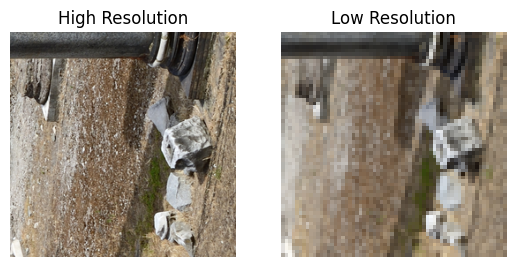

In [6]:
print("Length of train_dataloader: {}".format(len(train_dataloader)))
hrs, lrs = next(iter(train_dataloader))

hr = hrs[0].permute((1, 2, 0))
lr = lrs[0].permute((1, 2, 0))

print(">> Size of high-res image:", hr.size())
print(">> Size of low-res image:", lr.size())
fig, axs = plt.subplots(1, 2)

axs[0].imshow(hr)
axs[0].set_title('High Resolution')
axs[1].imshow(lr)
axs[1].set_title('Low Resolution')

for ax in axs.flat:
    ax.axis('off')

plt.show()

Length of valid_dataloader: 100
>> Size of high-res image: torch.Size([1416, 2040, 3])
>> Size of low-res image: torch.Size([354, 510, 3])


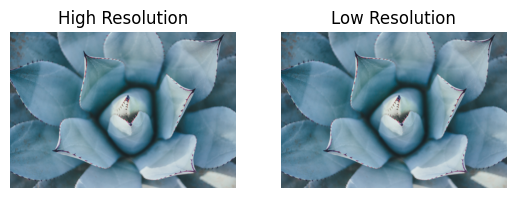

In [7]:
print("Length of valid_dataloader: {}".format(len(valid_dataloader)))
hrs, lrs = next(iter(valid_dataloader))

hr = hrs[0].permute((1, 2, 0))
lr = lrs[0].permute((1, 2, 0))

print(">> Size of high-res image:", hr.size())
print(">> Size of low-res image:", lr.size())
fig, axs = plt.subplots(1, 2)

axs[0].imshow(hr)
axs[0].set_title('High Resolution')
axs[1].imshow(lr)
axs[1].set_title('Low Resolution')

for ax in axs.flat:
    ax.axis('off')

plt.show()

# MODEL ARCHITECTURE

In [8]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import math
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def get_upsample_filter(size):
    """Make a 2D bilinear kernel suitable for upsampling"""
    factor = (size + 1) // 2
    if size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:size, :size]
    filter = (1 - abs(og[0] - center) / factor) * \
             (1 - abs(og[1] - center) / factor)
    return torch.from_numpy(filter).float()

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_input = nn.Conv2d(in_channels = 3, out_channels=64, kernel_size= 3, stride=1, padding=1, bias= False)
        self.relu = nn.ReLU()

        self.convrtI = nn.ConvTranspose2d(in_channels= 3, out_channels= 3, kernel_size= 4, stride= 2, padding = 1, bias= False)
        self.convrtR = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=3, stride=1, padding=1, bias=False)
        self.convrtF = nn.Sequential(
            nn.Conv2d(in_channels= 64, out_channels= 64, kernel_size= 3, stride= 1, padding= 1, bias = False),
            nn.ReLU(),
            nn.Conv2d(in_channels= 64, out_channels= 64, kernel_size= 3, stride= 1, padding= 1, bias = False),
            nn.ReLU(),
            nn.Conv2d(in_channels= 64, out_channels= 64, kernel_size= 3, stride= 1, padding= 1, bias = False),
            nn.ReLU(),
            nn.Conv2d(in_channels= 64, out_channels= 64, kernel_size= 3, stride= 1, padding= 1, bias = False),
            nn.ReLU(),
            nn.Conv2d(in_channels= 64, out_channels= 64, kernel_size= 3, stride= 1, padding= 1, bias = False),
            nn.ReLU(),
            nn.Conv2d(in_channels= 64, out_channels= 64, kernel_size= 3, stride= 1, padding= 1, bias = False),
            nn.ReLU(),
            nn.Conv2d(in_channels= 64, out_channels= 64, kernel_size= 3, stride= 1, padding= 1, bias = False),
            nn.ReLU(),
            nn.Conv2d(in_channels= 64, out_channels= 64, kernel_size= 3, stride= 1, padding= 1, bias = False),
            nn.ReLU(),
            nn.Conv2d(in_channels= 64, out_channels= 64, kernel_size= 3, stride= 1, padding= 1, bias = False),
            nn.ReLU(),
            nn.Conv2d(in_channels= 64, out_channels= 64, kernel_size= 3, stride= 1, padding= 1, bias = False),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels= 64, kernel_size= 4, stride= 2, padding=1, bias = False),
            nn.ReLU())

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            if isinstance(m, nn.ConvTranspose2d):
                c1, c2, h, w = m.weight.data.size()
                weight = get_upsample_filter(h)
                m.weight.data = weight.view(1, 1, h, w).repeat(c1, c2, 1, 1)
                if m.bias is not None:
                    m.bias.data.zero_()
    
    def forward(self, x):

        out = self.relu(self.conv_input(x))

        #X2
        convrtF = self.convrtF(out)
        convrtI = self.convrtI(x)
        convrtR = self.convrtR(convrtF)
        
        x = convrtI + convrtR
        
        #X4
        convrtF = self.convrtF(convrtF)
        convrtI = self.convrtI(x)
        convrtR = self.convrtR(convrtF)
        
        return convrtI + convrtR
    
class L1_Charbonnier_loss(nn.Module):
    """L1 Charbonnierloss."""
    def __init__(self):
        super(L1_Charbonnier_loss, self).__init__()
        self.eps = 1e-6

    def forward(self, X, Y):
        diff = torch.add(X, -Y)
        error = torch.sqrt( diff * diff + self.eps )
        loss = torch.sum(error)/(X.shape[0]*X.shape[1]*X.shape[2]*X.shape[3])
        return loss


In [9]:
print(device)
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

cuda
1
Tesla P100-PCIE-16GB


# MODEL TRAINING

In [10]:
# ------------------------------ HYPERPARAMS ------------------------------ #
LR = 0.00001

NUM_EPOCHS = 5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')




In [11]:
class Network:
    def __init__(self, for_inference=False, train_dataloader=train_dataloader, valid_dataloader=valid_dataloader,
                 lr=LR,momentum = 0.9, weight_decay= 0.0005,step_size=10, gamma=1,
                 num_epochs=NUM_EPOCHS, device=DEVICE, run_id=None):
        
        self.for_inference = for_inference
        self.model = Net().to(device)
        self.device = device
        
        if not self.for_inference:
            self.loss_fn = L1_Charbonnier_loss().to(device)
            self.optimizer = torch.optim.SGD(self.model.parameters(), lr=LR, momentum= momentum, weight_decay= weight_decay)
            self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=step_size, gamma=gamma)

            self.train_dataloader = train_dataloader
            self.valid_dataloader = valid_dataloader
            self.num_epochs = num_epochs

            self.run_id = run_id
    
    def save_network(self, epoch, train_loss, valid_loss, checkpoint_path):
        checkpoint = {
            'epoch': epoch,
            'train_loss': train_loss,
            'valid_loss': valid_loss,
            'model': self.model.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'learning_rate_scheduler': self.scheduler.state_dict(),
            'network': self
        }
        torch.save(checkpoint, checkpoint_path)

    def load_network(self, checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        if not self.for_inference:
            #self = torch.load(checkpoint['network'])
            self.model.load_state_dict(checkpoint['model'])
            self.optimizer.load_state_dict(checkpoint['optimizer'])
            self.scheduler.load_state_dict(checkpoint['learning_rate_scheduler'])
        return checkpoint['epoch'], checkpoint['train_loss'], checkpoint['valid_loss']
    
    def train_step(self, lr_images, hr_images):
        lr_images, hr_images = lr_images.to(self.device), hr_images.to(self.device)
        self.optimizer.zero_grad()
        sr_images = self.model(lr_images)
        loss = self.loss_fn(sr_images, hr_images)
        loss.backward()
        self.optimizer.step()
        return loss.item()
    
    def valid_step(self, lr_images, hr_images):
        lr_images, hr_images = lr_images.to(self.device), hr_images.to(self.device)
        sr_images = self.model(lr_images)
        loss = self.loss_fn(sr_images, hr_images)
        return loss.item()
    
    def train_model(self):

        last_valid_loss = float('inf')
        wandb.init(project='LAPSRN',
                   resume='allow',
                   config={
                       'Optimizer': "SGD",
                       'lr': LR,
                   },
                   id=self.run_id)
        wandb.watch(self.model)

        for epoch in range(self.num_epochs):
            
            start = time.time()

            # ------------------- TRAIN -------------------
            self.model.train()
            train_epoch_loss = 0

            for hr_images, lr_images in tqdm(self.train_dataloader, desc=f'Epoch {epoch+1}/{self.num_epochs}'):
                loss = self.train_step(lr_images, hr_images)
                train_epoch_loss += loss
            
            del hr_images
            del lr_images
            gc.collect()
            torch.cuda.empty_cache()
            
            train_epoch_loss /= len(self.train_dataloader)

            end = time.time()

            # ------------------- VALID -------------------
            self.model.eval()
            with torch.no_grad():
                valid_epoch_loss = 0

                for hr_images, lr_images in tqdm(self.valid_dataloader, desc=f'Epoch {epoch+1}/{self.num_epochs}'):
                    loss = self.valid_step(lr_images, hr_images)
                    valid_epoch_loss += loss
                
                del hr_images
                del lr_images
                gc.collect()
                torch.cuda.empty_cache()
                
                valid_epoch_loss /= len(self.valid_dataloader)
            
            # ------------------- LOG -------------------
            wandb.log({
                'train_loss': train_epoch_loss,
                'valid_loss': valid_epoch_loss,
                'learning_rate': self.optimizer.param_groups[0]['lr']
            })
            self.scheduler.step()

            # ------------------- VERBOSE -------------------
            print(f'Epoch {epoch+1}/{self.num_epochs} | Train Loss: {train_epoch_loss:.4f} | Valid Loss: {valid_epoch_loss:.4f} | Time: {end-start:.2f}s')

            # ------------------- CHECKPOINT -------------------
            self.save_network(epoch, train_epoch_loss, valid_epoch_loss, 'model_checkpoint_latest.pth')
            if valid_epoch_loss < last_valid_loss:
                last_valid_loss = valid_epoch_loss
                self.save_network(epoch, train_epoch_loss, valid_epoch_loss, 'model_checkpoint_best.pth')
                print("New best checkpoint saved!")
        
        wandb.finish()
    
    def inference(self, lr_image, hr_image=None):
        """
        - lr_image: torch.Tensor
            3D Tensor (C, H, W)
        - hr_image: torch.Tesnor
            3D Tensor (C, H, W). This parameter is optional, for comparing the model output and the 
            ground-truth high-res image. If used solely for inference, skip this. Default is None/
        """
        lr_image = lr_image.unsqueeze(0).to(self.device)
        with torch.no_grad():
            sr_image = self.model(lr_image)
        
        lr_image = lr_image.squeeze(0)
        sr_image = sr_image.squeeze(0)
        
        print(">> Size of low-res image:", lr_image.size())
        print(">> Size of super-res image:", sr_image.size())
        if hr_image != None:
            print(">> Size of high-res image:", hr_image.size())
        
        if hr_image != None:
            fig, axes = plt.subplots(1, 3, figsize=(10, 6))
            axes[0].imshow(lr_image.cpu().detach().permute((1, 2, 0)))
            axes[0].set_title('Low Resolution')
            axes[1].imshow(sr_image.cpu().detach().permute((1, 2, 0)))
            axes[1].set_title('Super Resolution')
            axes[2].imshow(hr_image.cpu().detach().permute((1, 2, 0)))
            axes[2].set_title('High Resolution')
            for ax in axes.flat:
                ax.axis('off')
        else:
            fig, axes = plt.subplots(1, 2, figsize=(10, 6))
            axes[0].imshow(lr_image.cpu().detach().permute((1, 2, 0)))
            axes[0].set_title('Low Resolution')
            axes[1].imshow(sr_image.cpu().detach().permute((1, 2, 0)))
            axes[1].set_title('Super Resolution')
            for ax in axes.flat:
                ax.axis('off')
        
        plt.tight_layout()        
        plt.show()
        
        return sr_image    
    
    def train_model_continue(self, checkpoint_path):
        
        start_epoch, train_loss, valid_loss = self.load_network(checkpoint_path)
        print("Previous train loss: ", train_loss)
        print("Previous valid loss: ", valid_loss)
        print("------------------- Resuming training -------------------")
        self.num_epochs -= start_epoch
        self.train_model()

In [63]:
#lapsrn = Network(run_id='LAPSRN')
#num_params = sum(p.numel() for p in lapsrn.model.parameters() if p.requires_grad)
#print("Number of learnable parameters: ", num_params)

In [12]:
lapsrn = Network(run_id='LAPSRN')
lapsrn.load_network('/kaggle/input/models107/models-107epochs/model_checkpoint_best.pth')
lapsrn.optimizer = torch.optim.SGD(lapsrn.model.parameters(), lr=0.00001/2, momentum= 0.9, weight_decay= 0.0005)
lapsrn.scheduler = optim.lr_scheduler.StepLR(lapsrn.optimizer, step_size=100, gamma=1)
lapsrn.num_epochs = 5

In [13]:
wandb.login(key='be280a70fa6801e424127a19762b64e066f313c6')
lapsrn.train_model()

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: bth-beats. Use `wandb login --relogin` to force relogin


Epoch 1/5: 100%|██████████| 100/100 [00:31<00:00,  3.16it/s]


Epoch 1/5 | Train Loss: 0.0843 | Valid Loss: 0.0757 | Time: 982.05s
New best checkpoint saved!


Epoch 2/5: 100%|██████████| 100/100 [00:24<00:00,  4.01it/s]


Epoch 2/5 | Train Loss: 0.0842 | Valid Loss: 0.0756 | Time: 788.60s
New best checkpoint saved!


Epoch 3/5: 100%|██████████| 100/100 [00:24<00:00,  4.01it/s]


Epoch 3/5 | Train Loss: 0.0842 | Valid Loss: 0.0756 | Time: 786.91s
New best checkpoint saved!


Epoch 4/5: 100%|██████████| 100/100 [00:24<00:00,  4.03it/s]


Epoch 4/5 | Train Loss: 0.0841 | Valid Loss: 0.0755 | Time: 788.37s
New best checkpoint saved!


Epoch 5/5: 100%|██████████| 100/100 [00:24<00:00,  4.01it/s]


Epoch 5/5 | Train Loss: 0.0841 | Valid Loss: 0.0755 | Time: 786.27s
New best checkpoint saved!


wandb: WARNING No requirements.txt found, not creating job artifact. See https://docs.wandb.ai/guides/launch/create-job


>> Size of low-res image: torch.Size([3, 64, 64])
>> Size of super-res image: torch.Size([3, 256, 256])


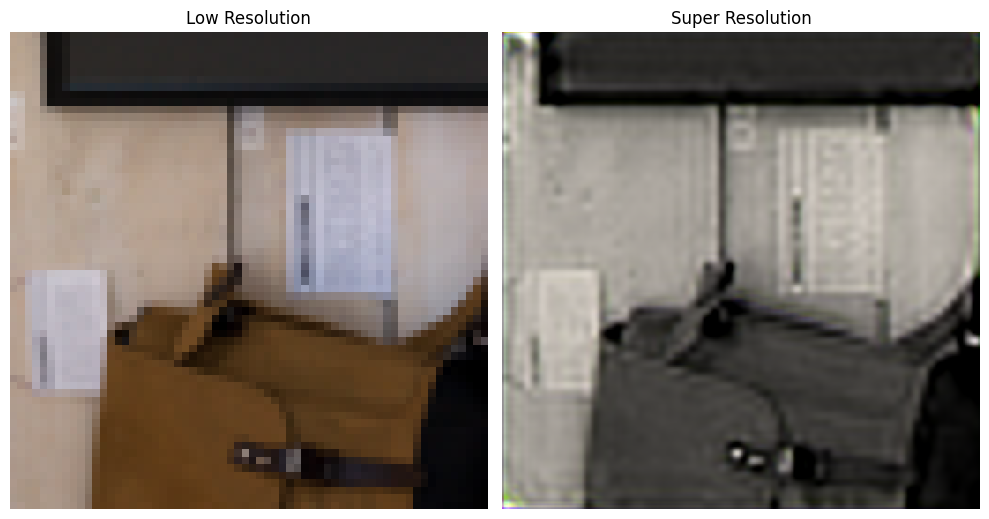

True

In [53]:
hi, low = train_dataloader.dataset.__getitem__(4)

_hi = lapsrn.inference(low)
_hi = _hi.detach().cpu()

import matplotlib.pyplot as plt
import cv2 as cv

out1 = _hi.detach().cpu().numpy()
out2 = torch.transpose(torch.transpose(_hi, 0, 1), 1, 2).detach().cpu().numpy()

cv.imwrite('./output.png', out)

[](http://)

# TEST

## TEST DATASET

In [ ]:
class TestDataset(Dataset):
    def __init__(self, hr_images_path):
        super(TestDataset, self).__init__()
        hr_images_list = os.listdir(hr_images_path)
        self.hr_images_list = [hr_images_path + image_name for image_name in hr_images_list if image_name.endswith('HR.png')]
    
    def __getitem__(self, idx):
        hr_image_path = self.hr_images_list[idx]
        lr_image_path = hr_image_path.replace('HR', 'LR')
        
        hr_image = Image.open(hr_image_path)
        lr_image = Image.open(lr_image_path)
        
        hr_image = transforms.functional.to_tensor(hr_image)
        lr_image = transforms.functional.to_tensor(lr_image)
        
        return hr_image, lr_image
        
    def __len__(self):
        return len(self.hr_images_list)

In [ ]:
SET5_PATH = "/kaggle/input/super-resolution-hust/Super Resolution HUST/Set5/image_SRF_4/"
SET14_PATH = "/kaggle/input/super-resolution-hust/Super Resolution HUST/Set14/image_SRF_4/"
URBAN100_PATH = "/kaggle/input/super-resolution-hust/Super Resolution HUST/Urban100/image_SRF_4/"
BSD100_PATH = "/kaggle/input/super-resolution-hust/Super Resolution HUST/BSD100/image_SRF_4/"

set5_dataset = TestDataset(hr_images_path=SET5_PATH)
set14_dataset = TestDataset(hr_images_path=SET14_PATH)
urban100_dataset = TestDataset(hr_images_path=URBAN100_PATH)
bsd100_dataset = TestDataset(hr_images_path=BSD100_PATH)

print(len(set5_dataset), len(set14_dataset), len(urban100_dataset), len(bsd100_dataset))

# set5_dataloader = DataLoader(set5_dataset, batch_size=1)
# set14_dataloader = DataLoader(set14_dataset, batch_size=1)
# urban100_dataloader = DataLoader(urban100_dataset, batch_size=1)
# bsd100_dataloader = DataLoader(bsd100_dataset, batch_size=1)

## TEST METRICS

In [ ]:
def test(network, hr_images, lr_images, show_image=False, idx=0):
    """
    - network: Network
        Model to be tested.
    - hr_images: torch.Tensor
        4D Tensor (B, C, H, W)
    - lr_images: torch.Tensor
        4D Tensor (B, C, H, W)
    - show_image: bool
        Whether to add an inference step and show lr-sr-hr images side by side.
    - idx: int
        Index of image in batch, chosen to be shown. Default is 0.
        NOTE: Please be careful to keep idx within the batch size.
    """
    hr_images = hr_images.cuda()
    lr_images = lr_images.cuda()
    
    def calculate_psnr(original_images, reconstructed_images):

        if original_images.shape != reconstructed_images.shape:
            raise ValueError("Images must have the same shape")

        mse = F.mse_loss(original_images, reconstructed_images, reduction='mean')
        max_pixel_value = 1.0
        psnr_value = 10 * torch.log10((max_pixel_value ** 2) / mse)
        return psnr_value.item()

    def calculate_ssim(original_images, reconstructed_images):

        if original_images.shape != reconstructed_images.shape:
            raise ValueError("Images in the batch must have the same shape")

        ssim_value = ssim(original_images, reconstructed_images) 
        return ssim_value.item()
        
    network.model.eval()
    with torch.no_grad():
        sr_images = network.model(lr_images)
    
    loss_func = nn.L1Loss(reduction='mean')
    l1_loss = loss_func(hr_images.cpu(), sr_images.cpu()).item()
    psnr_value = calculate_psnr(hr_images.cpu(), sr_images.cpu())
    ssim_value = calculate_ssim(hr_images.cpu(), sr_images.cpu())
    
    #if show_image:
    #    network.inference(lr_images[idx], hr_images[idx])
    
    return l1_loss, psnr_value, ssim_value

In [ ]:
def test_on_dataset(model, dataset, IDX):
    l1_batch_loss = 0
    psnr_batch_value = 0
    ssim_batch_value = 0
    for i in range(len(dataset)):
        hr_image, lr_image = dataset[i]
        if hr_image.shape[0] != 3:
            hr_image = hr_image.expand(3, -1, -1)
            lr_image = lr_image.expand(3, -1, -1)
        hr_image = hr_image.unsqueeze(0)
        lr_image = lr_image.unsqueeze(0)

        if i in IDX:
            l1_loss, psnr_value, ssim_value = test(model, hr_image, lr_image, show_image=True)
        else:
            l1_loss, psnr_value, ssim_value = test(model, hr_image, lr_image, show_image=False)

        l1_batch_loss += l1_loss
        psnr_batch_value += psnr_value
        ssim_batch_value += ssim_value

    print("Metrics across " + str(len(dataset)) + " images:")
    print(f"> L1 Loss: {l1_batch_loss/len(dataset):.4f}")
    print(f"> PSNR: {psnr_batch_value/len(dataset):.4f}")
    print(f"> SSIM: {ssim_batch_value/len(dataset):.4f}")

## TEST MODEL

In [ ]:
# ---------- LOAD FROM MODEL CHECKPOINT ---------- #
#gc.collect()
#torch.cuda.empty_cache()
#model = Network(for_inference=True)
# model.load_checkpoint('/kaggle/input/checkpoint-rcan/final_network/model_checkpoint_best.pth')

In [ ]:
# ---------- LOAD FROM LATEST CHECKPOINT ---------- #
#gc.collect()
#torch.cuda.empty_cache()
#model = Network(for_inference=True)
# model.load_checkpoint('/kaggle/input/checkpoint-rcan/final_network/model_checkpoint_latest.pth')

In [ ]:
# ---------- LOAD ENTIRE NETWORK ---------- #
gc.collect()
torch.cuda.empty_cache()

## TEST RESULTS

In [ ]:
# -------------------- SET5 -------------------- #
IDX = list(range(5))
test_on_dataset(lapsrn, set5_dataset, IDX)

In [ ]:
# -------------------- SET14 -------------------- #
random.seed(1989)
IDX = random.choices(list(range(14)), k=5)
test_on_dataset(lapsrn, set14_dataset, IDX)

In [ ]:
# -------------------- URBAN100 -------------------- #
random.seed(1989)
IDX = random.choices(list(range(100)), k=5)
test_on_dataset(lapsrn, urban100_dataset, IDX)

In [ ]:
# -------------------- BSD100 -------------------- #
random.seed(1989)
IDX = random.choices(list(range(100)), k=5)
test_on_dataset(lapsrn, bsd100_dataset, IDX)

# INFERENCE

In [ ]:
#from torchvision import datasets

#transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

#trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
#trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True)

In [ ]:
#image, _ = next(iter(trainloader))
#image = image.squeeze(0)
#image = image.expand(3, -1, -1)
#model.inference(image)

# END